In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Convolution2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import scipy.stats as stats


In [2]:
# Step 1: Load Data
cols = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', sep=',', on_bad_lines='skip', names=cols)
df = df.dropna()
df['z-axis'] = df['z-axis'].str.rstrip(';').astype(float)

In [3]:
# Step 2: Extract User 8's Data
df_8 = df[df['user'] == 8]

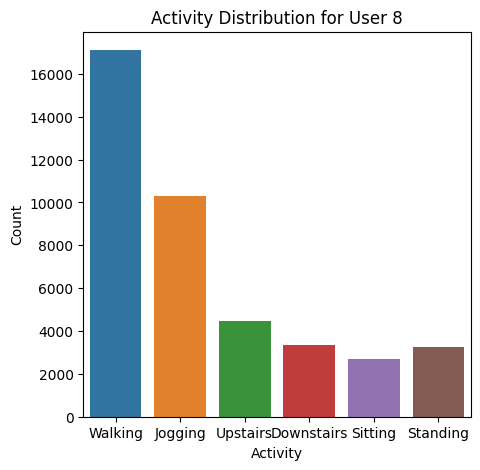

In [4]:
# Step 3: Visualize Activity Distribution
plt.figure(figsize=(5, 5))
sns.countplot(x='activity', data=df_8, hue='activity')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Activity Distribution for User 8')
plt.show()

In [6]:
# Step 5: Encode Labels
label = LabelEncoder()
df_8['label'] = label.fit_transform(df_8['activity'])

/var/folders/mn/35k8vrvj7z9046dsf_t68vzh0000gn/T/ipykernel_37074/1449644214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8['label'] = label.fit_transform(df_8['activity'])


In [7]:
# Step 6: Standardize Features
scaler = StandardScaler()
X = df_8[['x-axis', 'y-axis', 'z-axis']]
X = scaler.fit_transform(X)

In [8]:

scaled_X = pd.DataFrame(data=X, columns=['x-axis', 'y-axis', 'z-axis'])
scaled_X['label'] = df_8['label'].values

In [9]:
scaled_X.shape

(41188, 4)

In [10]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [11]:
# Step 7: Create Overlapping Windows
def get_windows(df, window_size, step_size):
    windows, labels = [], []
    num_features = 3
    for i in range(0, len(df) - window_size, step_size):
        xs = df['x-axis'].values[i: i + window_size]
        ys = df['y-axis'].values[i: i + window_size]
        zs = df['z-axis'].values[i: i + window_size]
        label = stats.mode(df['label'][i: i + window_size])[0]
        windows.append([xs, ys, zs])
        labels.append(label)
    windows = np.asarray(windows).reshape(-1, window_size, num_features)
    labels = np.asarray(labels)
    return windows, labels

In [12]:
# Create windows with a size of 100 and a step of 50
window_size, step_size = 100, 50
x, y = get_windows(scaled_X, window_size, step_size)

In [13]:
x.shape, y.shape

((822, 100, 3), (822,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0, stratify=y)

In [15]:
# Reshape data for CNN
X_train = X_train.reshape(-1, window_size, 3, 1)
X_test = X_test.reshape(-1, window_size, 3, 1)

In [18]:
# Step 9: Define CNN Model
model = Sequential([
    Convolution2D(16, (2, 2), activation='relu', input_shape=X_train[0].shape),
    Dropout(0.1),
    Convolution2D(32, (2, 2), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 10: Train the Model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, verbose=1)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4652 - loss: 1.3655 - val_accuracy: 0.7939 - val_loss: 0.6727
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7945 - loss: 0.6111 - val_accuracy: 0.8364 - val_loss: 0.3848
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8475 - loss: 0.3985 - val_accuracy: 0.9152 - val_loss: 0.2458
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8811 - loss: 0.2917 - val_accuracy: 0.9152 - val_loss: 0.2055
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9248 - loss: 0.2123 - val_accuracy: 0.9273 - val_loss: 0.1780
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9491 - loss: 0.1574 - val_accuracy: 0.9333 - val_loss: 0.1686
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9565 - loss: 0.1254 - val_accuracy: 0.9273 - val_loss: 0.1516
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9555 - loss: 0.1229 - val_accuracy: 0.9455 - val_loss:

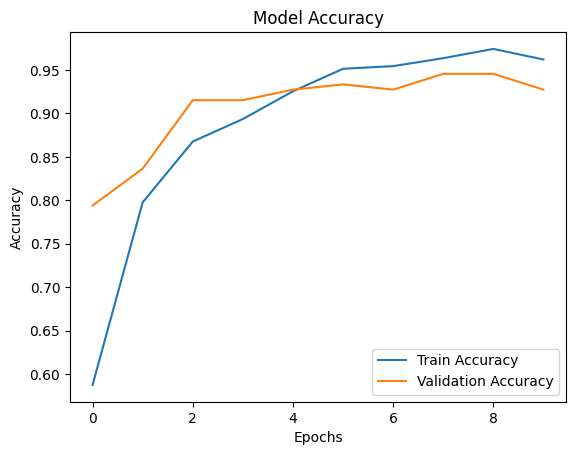

In [19]:
# Step 11: Visualize Training Performance
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


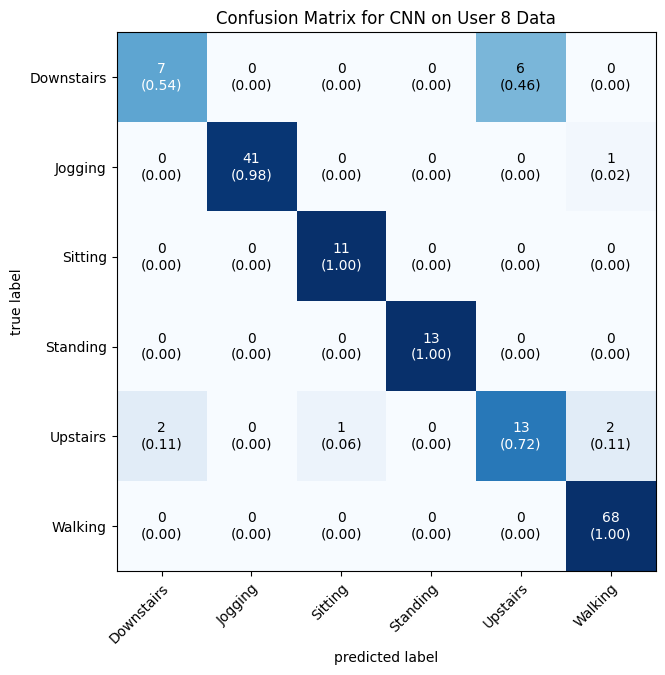

In [21]:
# Step 12: Evaluate Model with Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=-1)
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=matrix, class_names=label.classes_, show_normed=True, figsize=(7, 7))
plt.title('Confusion Matrix for CNN on User 8 Data')
plt.show()
